In [ ]:
from tensorflow.keras.applications import EfficientNetB3, DenseNet201, InceptionResNetV2, ResNet152V2, EfficientNetB7
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
import numpy as np

import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, AdamW, Nadam, Adadelta, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout,Activation, Flatten,
                    Conv2D,MaxPooling2D, BatchNormalization,GlobalAveragePooling2D)

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import backend as K
K.clear_session()

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 6),
          "figure.autolayout": True,
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'lines.linewidth': 2}

plt.rcParams.update(params)
%matplotlib inline

In [ ]:
!gdown 1YeEHCrWchGGJyf2KYRFbrdlXfa2MPe0l
!unzip ./data.zip

In [ ]:
# 設定參數
img_width, img_height = 300, 300
batch_size = 16

train_data_dir = './Train_'
test_data_dir = './Test_'

##資料增強
datagen = ImageDataGenerator(
    rescale=1. / 255,
    # horizontal_flip=True,
    rotation_range=30,  # 随机旋转的度数范围 (0-180)
    # width_shift_range=0.2,  # 水平平移的范围（相对于总宽度的比例）
    # height_shift_range=0.2,  # 垂直平移的范围（相对于总高度的比例）
    shear_range=0.2,  # 剪切强度（剪切角度的逆正切）
    zoom_range=0.1,  # 随机缩放的范围
    # fill_mode='nearest',  # 填充新创建像素的方法
    validation_split=0.2  # 設定驗證資料的比例
)

# 使用subset參數

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=['Jennie','Jisoo','Lisa','Rose','Others']
)

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',  # 'validation' subset
    classes=['Jennie','Jisoo','Lisa','Rose','Others']

)

# 讀取 sample.submission.csv 檔案
submission_df = pd.read_csv('./SampleSubmission.csv')
# 假設圖片是 JPG 格式，如果不是請相應調整
submission_df['id'] = submission_df['filename']
submission_df['filename'] = submission_df['filename'].apply(lambda x: f'{x}.jpg')
# 獲取 test_data_dir 中的所有檔案名稱
available_filenames = os.listdir(test_data_dir)
# 過濾出存在於資料夾中的圖片檔案
submission_df = submission_df[submission_df['filename'].isin(available_filenames)]
# 建立一個 DataFrame，包含排序後的圖片檔案名稱
test_df = pd.DataFrame({
    'filename': submission_df['filename']
})

test_datagen = ImageDataGenerator(rescale=1./255)

# 使用 flow_from_dataframe 方法
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_data_dir,
    x_col='filename',
    y_col=None,
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 461 images belonging to 5 classes.
Found 115 images belonging to 5 classes.
Found 577 validated image filenames.


In [ ]:
def plot_from_generator(generator, num_images=8, rows=2, cols=4):
    """ 顯示從生成器中取得的圖片 """
    data_batch = next(generator)
    images, labels = data_batch[0], data_batch[1]

    plt.figure(figsize=(cols * 3, rows * 3))

    # 顯示圖片和對應的標籤
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])

        # 找出標籤的索引
        label_index = int(labels[i].argmax())
        plt.title(f"Label: {label_index}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

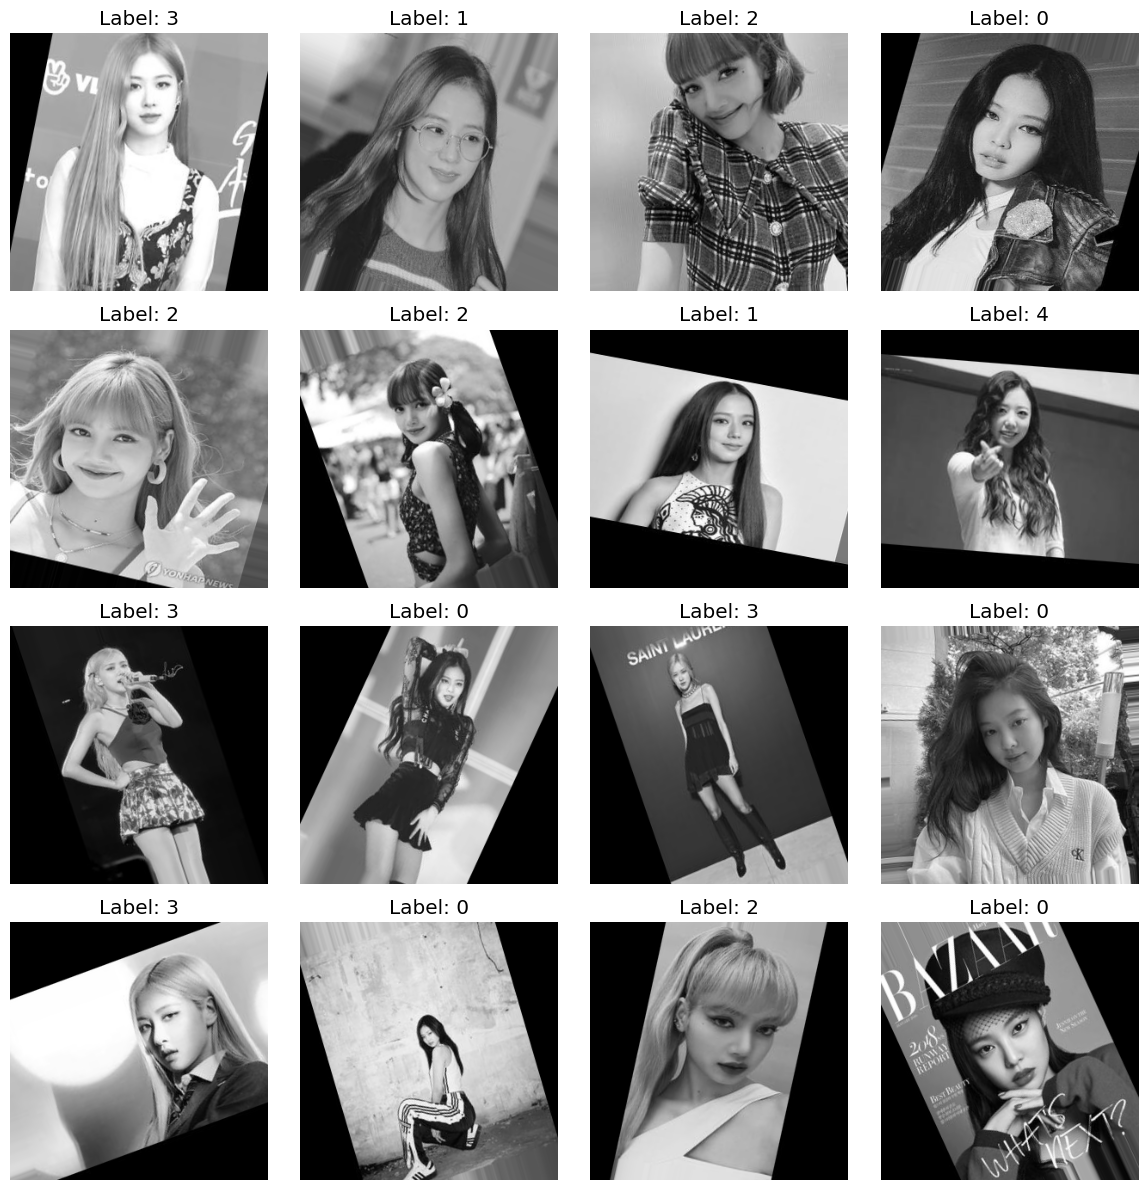

In [ ]:
plot_from_generator(train_generator, num_images=16, rows=4, cols=4)

# plt.savefig("./sample.pdf")

In [ ]:
base_model = DenseNet201(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height, 3))

# for layer in base_model.layers:
#     layer.trainable = False

In [ ]:
x = base_model.output
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)

# x = Dropout(0.5)(x)
x = Dense(64, activation = 'gelu')(x)
x = Dense(64, activation = 'gelu')(x)
x = Dense(64, activation = 'gelu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(5, activation = 'softmax')(x)

# This is the model we will train
model = Model(inputs = base_model.input, outputs = predictions)
# model = load_model('best_model_weights_tmp.keras')
# optimizer = Adam(learning_rate = 1e-4)
# optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
# optimizer = Nadam(learning_rate=1e-4)
# optimizer = Adadelta(learning_rate=1e-4, rho=0.95, epsilon=1e-07)
optimizer = SGD(learning_rate=0.0001, momentum=0.8, nesterov=False)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.summary()

In [ ]:
checkpoint = ModelCheckpoint('best_model_weights_tmp.keras', monitor = 'val_accuracy', save_best_only = True, mode = 'max', verbose = 1)

rlp = callbacks.ReduceLROnPlateau(
        monitor = 'val_accuracy',  # 是否進步的指標
        factor = 0.5,  # 以 factor 的倍數調整 learning rate
        patience = 10,  # 經過 patience 次沒有進步調整 learning rate
        verbose = 1,
        mode = 'max')

history = model.fit(
    train_generator,
    epochs = 300,
    validation_data = validation_generator,
    callbacks = [checkpoint, rlp]
)

Epoch 1/300


2024-03-17 02:02:28.383165: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fea26662a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-17 02:02:28.383281: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
I0000 00:00:1710612148.523861 2131226 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 [==============================] - ETA: 0s - loss: 1.6443 - accuracy: 0.1996
Epoch 1: val_accuracy improved from -inf to 0.15652, saving model to best_model_weights_tmp.keras
58/58 [==============================] - 132s 674ms/step - loss: 1.6443 - accuracy: 0.1996 - val_loss: 1.6362 - val_accuracy: 0.1565 - lr: 1.0000e-04
Epoch 2/300
58/58 [==============================] - ETA: 0s - loss: 1.6188 - accuracy: 0.2039
Epoch 2: val_accuracy improved from 0.15652 to 0.21739, saving model to best_model_weights_tmp.keras
58/58 [==============================] - 21s 365ms/step - loss: 1.6188 - accuracy: 0.2039 - val_loss: 1.6224 - val_accuracy: 0.2174 - lr: 1.0000e-04
Epoch 3/300
58/58 [==============================] - ETA: 0s - loss: 1.6087 - accuracy: 0.2169
Epoch 3: val_accuracy did not improve from 0.21739
58/58 [==============================] - 18s 300ms/step - loss: 1.6087 - accuracy: 0.2169 - val_loss: 1.6292 - val_accuracy: 0.1478 - lr: 1.0000e-04
Epoch 4/300
58/58 [==========

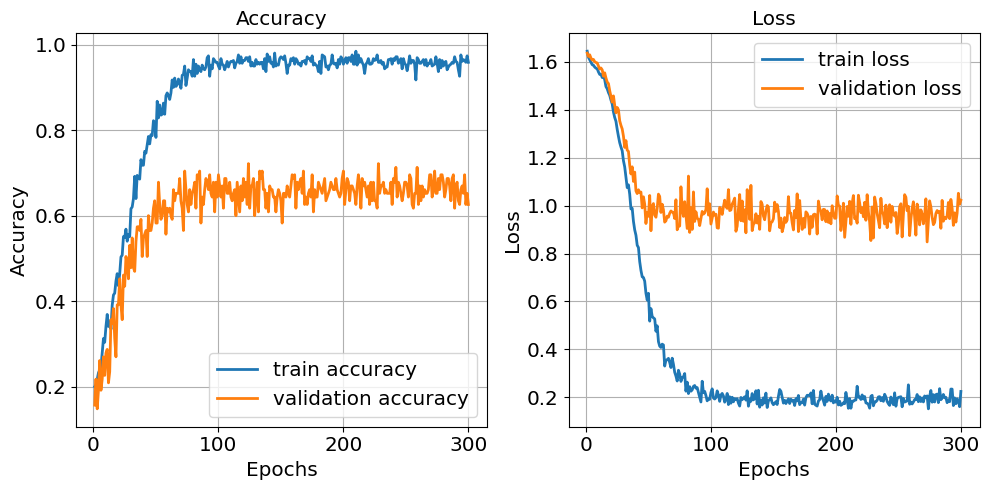

In [ ]:
# 獲取歷史數據
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Accuracy 曲線
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'train accuracy')
plt.plot(epochs_range, val_acc, label = 'validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss 曲線
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'train loss')
plt.plot(epochs_range, val_loss, label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("./result.pdf")
plt.show()

15/15 [==============================] - 6s 168ms/step


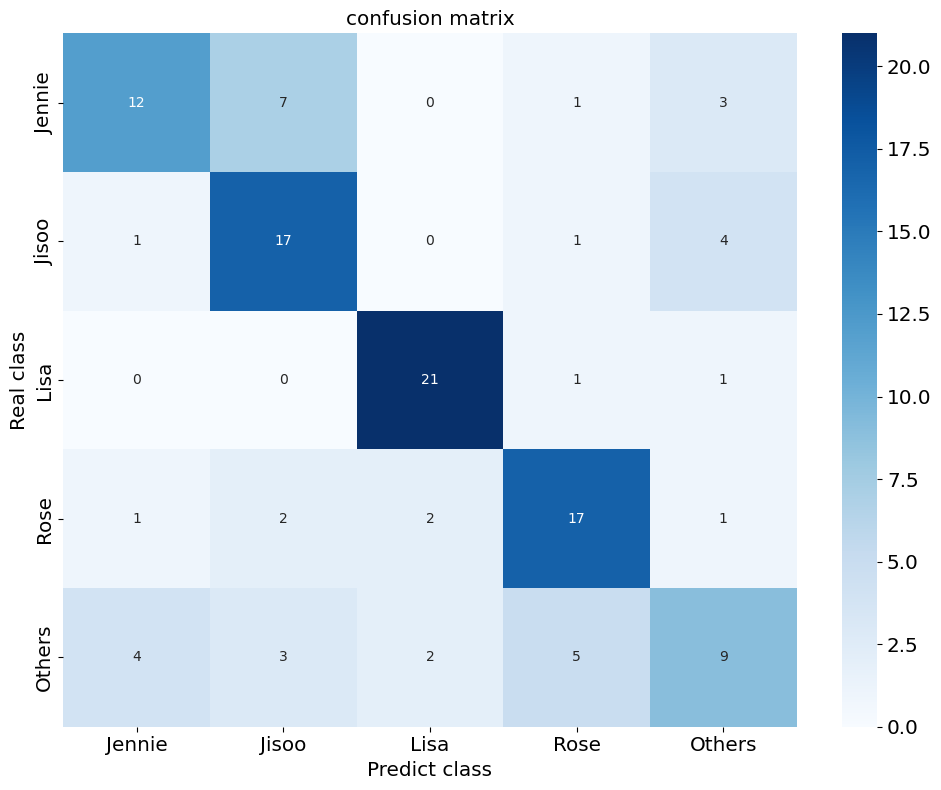

In [ ]:
from sklearn.metrics import confusion_matrix

model.load_weights('best_model_weights_tmp.keras')

# 1. 使用模型進行預測
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # 取得預測的類別索引
y_true = validation_generator.classes  # 取得真實的類別索引

# 2. 產生混淆矩陣
cm = confusion_matrix(y_true, y_pred_classes)

# 3. 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
plt.ylabel('Real class')
plt.xlabel('Predict class')
plt.title('confusion matrix')
plt.savefig("./confusion_matrix.pdf")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# 1. 使用模型在驗證集上進行預測
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# 獲取真實的標籤
y_true = validation_generator.classes

# 2. 使用 scikit-learn 計算 precision 和 recall
report = classification_report(y_true, y_pred_classes, target_names=list(validation_generator.class_indices.keys()))

print(report)

accuracy = np.mean(y_pred_classes == y_true)
if accuracy >= 0.90:
    model.save('best_model_weights_optimal.keras')
    print("Model updated: ./best_model_weights_optimal.keras")

15/15 [==============================] - 2s 157ms/step
              precision    recall  f1-score   support

      Jennie       0.53      0.43      0.48        23
       Jisoo       0.56      0.78      0.65        23
        Lisa       0.84      0.91      0.87        23
        Rose       0.68      0.65      0.67        23
      Others       0.71      0.52      0.60        23

    accuracy                           0.66       115
   macro avg       0.66      0.66      0.65       115
weighted avg       0.66      0.66      0.65       115



In [ ]:
filenames = [filename.split('/')[-1] for filename in test_generator.filenames]  # 只取文件名，去除路徑
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

submission_df = pd.read_csv('./SampleSubmission.csv')
submission_df = submission_df.set_index('filename')   # 確保這裡的列名和 CSV 檔案中的一致
submission_df = submission_df.reindex(filenames)  # 重新索引以匹配 filenames 的順序
submission_df = submission_df.reset_index()

submission_df['filename'] = submission_df['filename'].str.replace('.jpg', '', regex=False)
submission_df['label'] = predicted_classes  # 確保這裡的 'class' 是預測類別

submission_df.to_csv('./{0}_submission_{1}.csv'.format(str(round(accuracy, 2)).replace(".", ""), datetime.datetime.now().strftime("%Y-%m-%d_%X").replace(":", "")), index=False)  # 確保路徑正確

73/73 [==============================] - 11s 100ms/step
